In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

regiones={}
class region:
  def __init__(self, country, state, type_, dates, population):
    self.country=country
    self.state=state
    self.type_=type_
    self.id=len(regiones)
    self.population=population
    regiones[pais+'_'+estado]=self
    self.df=pd.DataFrame(index=dates, columns=['New','Active'])

!rm -f datos.zip
!rm -rf datos
!wget 'https://robertohincapie.com/qetuo1357/datos.zip'
!unzip -q datos.zip
!rm -f datos.zip

translate={'Alberta':'Alberta','BC':'British Columbia','Manitoba':'Manitoba','New Brunswick':'New Brunswick','NL':'Newfoundland and Labrador',
'NWT':'Northwest Territories','Nova Scotia':'Nova Scotia','Nunavut':'Nunavut', 'Ontario':'Ontario', 'PEI':'Prince Edward Island',
'Quebec':'Quebec', 'Saskatchewan':'Saskatchewan', 'Yukon':'Yukon','Repatriated':'Repatriated'}

states=list(translate.values()) #from provinces' list in Canada

#Canada and provinces daily cases
custom_date_parser = lambda x: datetime.strptime(x, "%d-%m-%Y")
#1. Daily case data in Canada
data=pd.read_csv("datos/CLEANED_Daily_cases-Canada_noQuot.csv", parse_dates=['date_report'], date_parser=custom_date_parser)
#print(data.head())
#Mobility data from air traffic
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m")

#2. Traffic data with origin and destination to Canada and specific to Manitoba (origin)
source_0=pd.read_csv("datos/CLEANED_OriginIntlToCanada__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Origin city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
dest_0=pd.read_csv("datos/CLEANED_DestIntlToCanada__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Destination city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
manitoba=pd.read_csv("datos/CLEANED_OriginIntlToManitoba__2010-2021.csv", sep=',', parse_dates=['Date'], date_parser=custom_date_parser)[['Origin city', 'Province / state','Country', 'Direct volume', 'Indirect volume', 'Total volume', 'Date']]
#print(manitoba.head())
#World Covid Data: 
#Cummulative: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
#deaths: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Recovered: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv
#3. Número de casos diarios reportados para todos los paises del mundo
world_new=pd.read_csv('datos/covid_world.csv', sep=',')

#Reduction of countries in world_new which we have no information
remove=["Burma","Cote d'Ivoire","Diamond Princess","Kosovo","MS Zaandam","West Bank and Gaza", "Summer Olympics 2020"]
for co in remove:
    world_new=world_new[world_new['Country/Region']!=co]
    
#4. us_new has the complete US covid new case data.     
#US_data: https://github.com/CSSEGISandData/COVID-19/blob/5b71a48af53f961c3ef99617647bab20571e2f4e/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
us_new=pd.read_csv('datos/us_covid.csv', sep=',') #Columns 0-10 contain data on the state, city, indexes, etc. 
#The dates where the data are located are in columns 11 to the end.
#the rows correspond to each state and city. 
us_new=us_new[us_new.columns[11:]].sum() #Total covid cases for the United States are the cumulative cases for the entire country.
#When the columns are summed, a single row is left which becomes pd.Series with the column headers as the index of the series. 
#print(us_new.head)
us_new.index=pd.to_datetime(us_new.index) #The US data are cumulative, I have to differentiate them in order to convert them into daily cases.
us_new=us_new.diff().fillna(0) 

#5. us_new2, the data of new covid cases for each state of the united states by day.
#Build a dataframe that gives me the covid cases by status by date.
us_new2=pd.read_csv('datos/us_covid.csv', sep=',') #Columns 0-10 contain data on the state, city, indexes, etc.  
datos=[]
cols=[]
remover=['American Samoa','Diamond Princess','Grand Princess','Guam','Northern Mariana Islands','Virgin Islands']
for st in us_new2['Province_State'].unique():
  if(st not in remover):
    tmp=us_new2[us_new2['Province_State']==st]
    tmp=tmp[tmp.columns[11:]].sum() 
    tmp.index=pd.to_datetime(tmp.index) #The US data are cumulative, I have to differentiate them in order to convert them into daily cases.
    tmp=tmp.diff().fillna(0) 
    datos.append(tmp)
    cols.append(st)
us_new2=pd.concat(datos, axis=1)
us_new2.columns=cols
#print(us_new2.head())
#us_new2.plot(figsize=(10,10))
#The us_new2 table has the daily covid data from the United States.

#6. Population data of the world, of all countries
#World population
#https://www.kaggle.com/tanuprabhu/population-by-country-2020
population=pd.read_csv('datos/population_by_country_2020.csv', sep=',')[['Country (or dependency)', 'Population (2020)']]
population.columns=['Country','Population']
population.loc[population.Country=='South Korea','Country']='Korea, South'
population.loc[population.Country=='DR Congo','Country']='Congo (Kinshasa)'
population.loc[population.Country=='Congo','Country']='Congo (Brazzaville)'
population.loc[population.Country=='Czech Republic (Czechia)','Country']='Czechia'
population.loc[population.Country=='Saint Kitts & Nevis','Country']='Saint Kitts and Nevis'
population.loc[population.Country=='St. Vincent & Grenadines','Country']='Saint Vincent and the Grenadines'
population.loc[population.Country=='Sao Tome & Principe','Country']='Sao Tome and Principe'
population.loc[population.Country=='Taiwan','Country']='Taiwan*'

#7. Population data for each state in Canada. 
#Canadian population
#https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
canada_pop=pd.read_csv('datos/canadian_population.csv',sep=';')
canada_pop.index=canada_pop['Geography']
pop={}
for st in states:
  if(st!='Repatriated'):
    print(st)
    pop[st]=canada_pop.loc[st]['Q2 2021']    

#8. Population data for each U.S. state


--2022-06-24 13:59:09--  https://robertohincapie.com/qetuo1357/datos.zip
Resolving robertohincapie.com (robertohincapie.com)... 190.8.176.107
Connecting to robertohincapie.com (robertohincapie.com)|190.8.176.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7018671 (6.7M) [application/zip]
Saving to: ‘datos.zip’

datos.zip           100%[===================>]   6.69M  19.6MB/s    in 0.3s    

2022-06-24 13:59:09 (19.6 MB/s) - ‘datos.zip’ saved [7018671/7018671]

Alberta
British Columbia
Manitoba
New Brunswick
Newfoundland and Labrador
Northwest Territories
Nova Scotia
Nunavut
Ontario
Prince Edward Island
Quebec
Saskatchewan
Yukon


In [ ]:
us_states=source_0[source_0['Country']=='United States']['Province / state'].unique().tolist()
#data.head()
#data[data['province']=='Alberta'][['standard_daily_cases14','daily_cases']].plot()
#plt.xlim([250,350])
#print(data[data['province']=='Alberta'][['standard_daily_cases14','daily_cases']].tail(10))
#Comparison of covid docket and traffic matrix states
#The first list is of new covid cases.
#The second list is from the traffic or mobility matrix. 
#for s1 in us_states:
#  if(s1 not in sorted(list(us_new2.columns))):
#    print(s1)

In [ ]:
#Data processing
#Process A
#Define in the dataframe the covid cases in each province of Canada. 
provs=data['province'].unique().tolist()
dates=data['date_report'].unique()
df=pd.DataFrame(index=dates, columns=provs)
df=df.fillna(0)
for i in range(len(data)):
    fecha=data.iloc[i]['date_report']
    prov=data.iloc[i]['province']
    num=data.iloc[i]['daily_cases']
    df.loc[fecha][prov]=num
    
for co in df.columns:
    df[co]=df[co].rolling(window=14, center=True, min_periods=1).mean()
co=['Daily_'+translate[c] for c in df.columns]
df.columns=co
df=df.fillna(0)

#Process B, daily cases from the U.S. states.
#From data source 5
for co in us_new2.columns: #For each U.S. case
  tmp=us_new2[co].rolling(window=14, center=True, min_periods=1).mean()
  tmp.name='Daily_'+co
  df=df.join(tmp)
#df.plot(figsize=(14,14))

countries=source_0.Country.unique().tolist() #Countries with traffic to canada
#Data frame conversion to pivot tables needed
def read(df, col, prefix=''):
    data=pd.pivot_table(df, values='Total volume', index='Date', columns=col, aggfunc=np.sum)
    data=data.asfreq('D', method='ffill')
    cols=data.columns
    cols=[prefix+co for co in cols]
    data.columns=cols
    data=data.fillna(0)
    data=data*10/30.42  #Correction factor and take it to passengers per day.
    return data

source=read(source_0, 'Country', prefix='From_')
dest=read(dest_0, 'Province / state', prefix='To_')

sourceUS=read(source_0[source_0['Country']=='United States'], 'Province / state', prefix='US_From_')

#source.plot()
#plt.figure(figsize=(10,10))
#dest.plot(figsize=(10,10))
cols_daily, cols_source, cols_dest, cols_us_source=df.columns, source.columns, dest.columns, sourceUS.columns

df=df.join(dest).join(source).join(sourceUS)
#df so far has data on new cases per day from the states of canada and the states of the united states.
#and the volume of traffic per day from each country and each U.S. state to Canada and from international to each state in Canada. 

#print('Fecha máxima: ',max(df.index))
#print(world_new.head())
fechas=world_new.columns[4:]
countries=list(world_new['Country/Region'].unique())
#print(df[df.index<pd.to_datetime('2021-05-15')].tail(20))
cols=['new_'+co for co in countries]#+['death_'+co for co in countries]+['recovered_'+co for co in countries]
#TODO: Do we leave the columns of new cases of the countries as with the prefix Daily_ or new_?

#Covid is a dataframe to attach new covid cases by country.
covid=pd.DataFrame(index=fechas, columns=cols)
covid=covid.fillna(0)
for i in tqdm(range(len(world_new))):
  country=world_new.iloc[i]['Country/Region']
  covid['new_'+country]+=world_new.iloc[i][fechas]
#Here we have aggregated covid data for each country. It had to be done because there are countries that appear several times for having regions.

covid.index=pd.to_datetime(covid.index)
covid=covid.asfreq('D', method='ffill')
for co in covid.columns:
    covid[co]=covid[co].rolling(window=14, center=True, min_periods=1).mean()
covid=covid.diff()
covid.fillna(0)
df=df.join(covid)

#Saving of canadian states population
#population of the canadian states
for st in states:
  if(st!='Repatriated'):
    df['Population_'+st]=pop[st]

#TODO: Load the population of the U.S. states


100%|██████████| 273/273 [00:00<00:00, 439.89it/s]


In [ ]:
## US Population
url = 'https://api.census.gov/data/2019/pep/population?get=COUNTY,POP,NAME,STATE&for=state:*'
USPop =(pd.read_csv(url))
USPop.drop(['STATE', 'state]','[["COUNTY"','Unnamed: 5'], axis=1, inplace=True)
for i, j in USPop.iterrows():
  df['Population_'+j['NAME']]=j['POP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
#Estimation of the number of active cases, simply by reducing the number of users newly infected after 14 days
for co in countries:
  newCases=list(df['new_'+co].values)
  n=5
  recovered=[0 for i in range(n)]+newCases[:-n]
  acum=np.cumsum(newCases)
  recov=np.cumsum(recovered)
  active=acum-recov
  df['active_'+co]=active


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Analizando:  Alberta


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  British Columbia


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Manitoba


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  New Brunswick


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Newfoundland and Labrador


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Northwest Territories


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Nova Scotia


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Nunavut


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Ontario


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Prince Edward Island


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Quebec


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Saskatchewan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Analizando:  Yukon


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

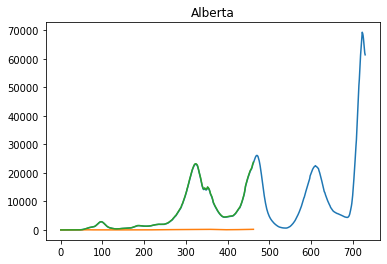

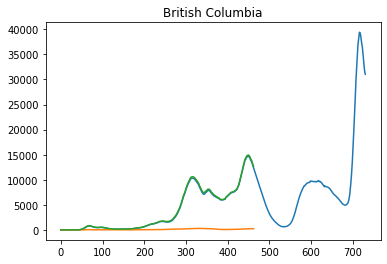

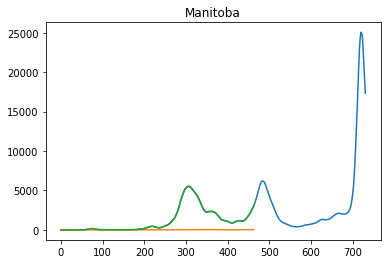

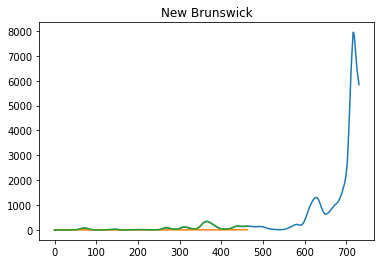

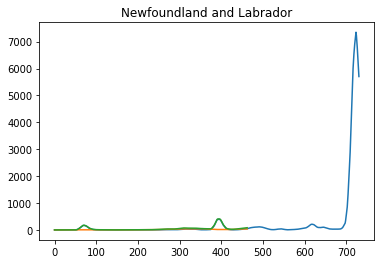

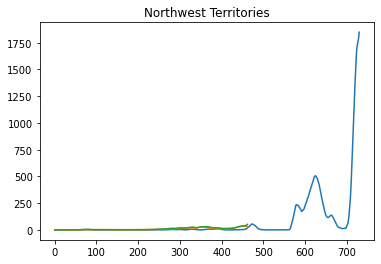

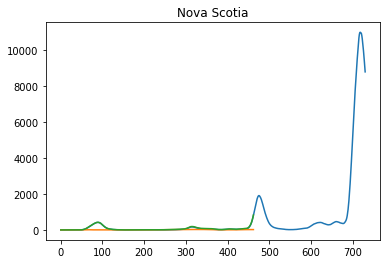

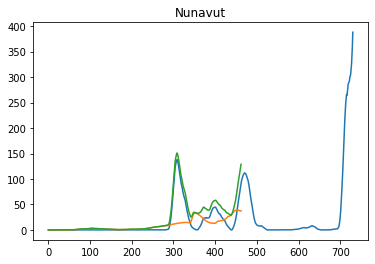

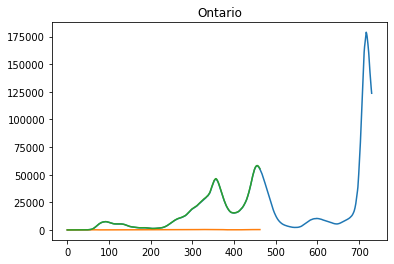

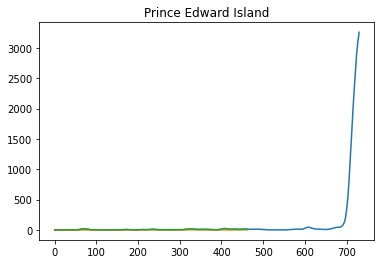

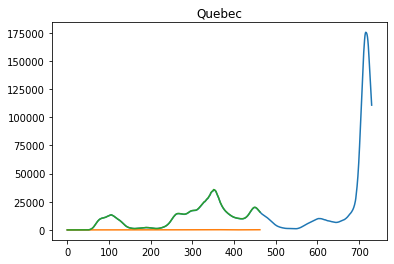

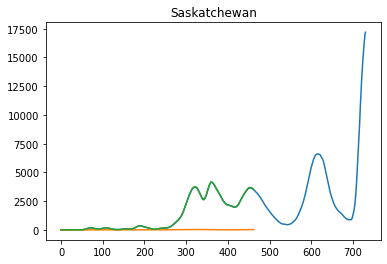

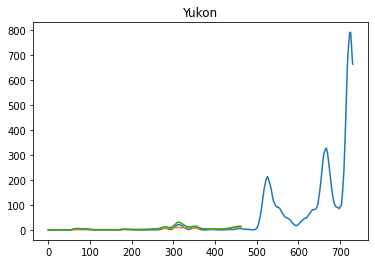

In [ ]:
df['new_US']=0
for ind in df.index:
    if(ind in us_new.index):
      df.loc[ind,'new_US']=us_new.loc[ind] #us_new were the country totals
    else:
      df.loc[ind,'new_US']=0 #us_new were the country totals
df['new_US']=df['new_US'].rolling(window=14, center=True, min_periods=1).mean().fillna(method='ffill').fillna(0)

newCases=list(df['new_US'].values)
n=14
recovered=[0 for i in range(n)]+newCases[:-n]
acum=np.cumsum(newCases)
recov=np.cumsum(recovered)
active=acum-recov
df['active_US']=active
#TODO: active cases for each of the U.S. states
# is to do the same process as above, but with all the states of the united states.

for st in states:
    newCases=list(df['Daily_'+st].values)
    n=14
    recovered=[0 for i in range(n)]+newCases[:-n]
    acum=np.cumsum(newCases)
    recov=np.cumsum(recovered)
    active=acum-recov
    df['active_'+st]=active
#This was the same but for each state in Canada.


#Population information storage
for co in countries:
    #print(co)
    if(co=='US'):
        co2='United States'
    else:
        co2=co
    row=population[population.Country==co2]['Population'].values[0]
    df['Population_'+co]=row

#df is Population_states of canada, Population_countries of the world, but is missing: Population_states of united states
#TODO: fill in the population of the united states



#df rows: 
    #Daily_xx x: canadian state: new cases on the state per day
    #active_xx x: number of active cases on countries
    #From_xx x: traffic volume from country xx
    #To_xx x: traffic volume to state xx
    #Population_xx: population on country xx
    
#I guess I have it all

def intensity(row, countries, region):
    #Get the intensity of covid infection to regions
    K=np.sum([row['To_'+co] for co in states if co!='Repatriated'])
    if(K>0):
      factor=row['To_'+region]/K
    else:
      factor=0
    Iown=row['active_'+region]
    Iext=0
    for i in range(len(countries)):
        if('From_'+countries[i] in row):
            #print('From_'+countries[i])
            Iext+=factor*row['From_'+countries[i]]*row['active_'+countries[i]]/row['Population_'+countries[i]]
            #print(Io)
    return Iown, Iext

for st in states:
    if(st!='Repatriated'):
        print('Analizando: ',st)
        Iown=[]
        Iext=[]
        for i in range(len(df)):
          tmp=intensity(df.iloc[i], countries, st)
          Iown.append(tmp[0])
          Iext.append(tmp[1])
        Iext=np.convolve(Iext, [1,1,1,1,1,1,1])[0:len(Iown)]
        plt.figure()
        plt.plot(Iown)
        plt.plot(Iext)
        plt.plot([Io+Ie for (Io,Ie) in zip(Iown, Iext)])
        plt.title(st)
        df['Intensity_'+st]=[Io+Ie for (Io,Ie) in zip(Iown, Iext)]
        df['Intensity_own'+st]=Iown
        df['Intensity_ext'+st]=Iext
        
df=df.fillna(0)

df=df[df.index<=datetime(2021,8,15)]

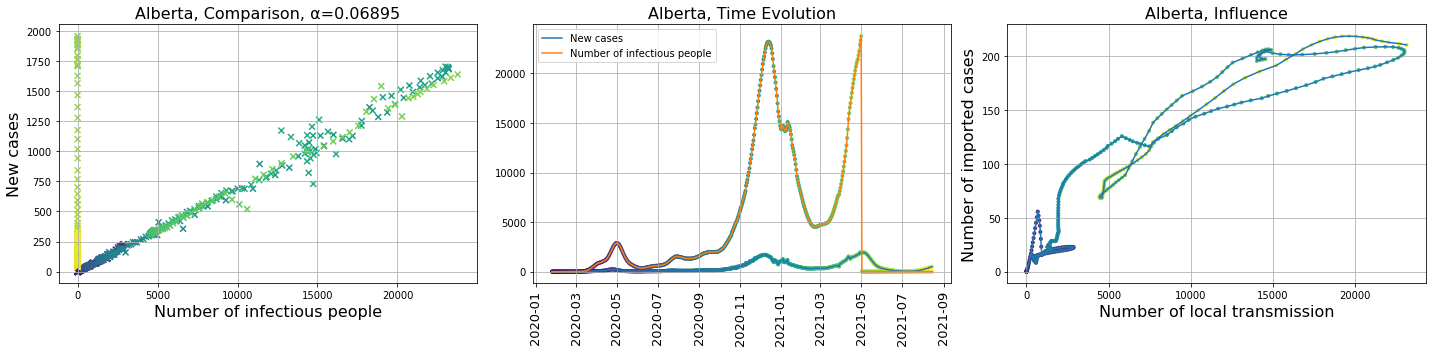

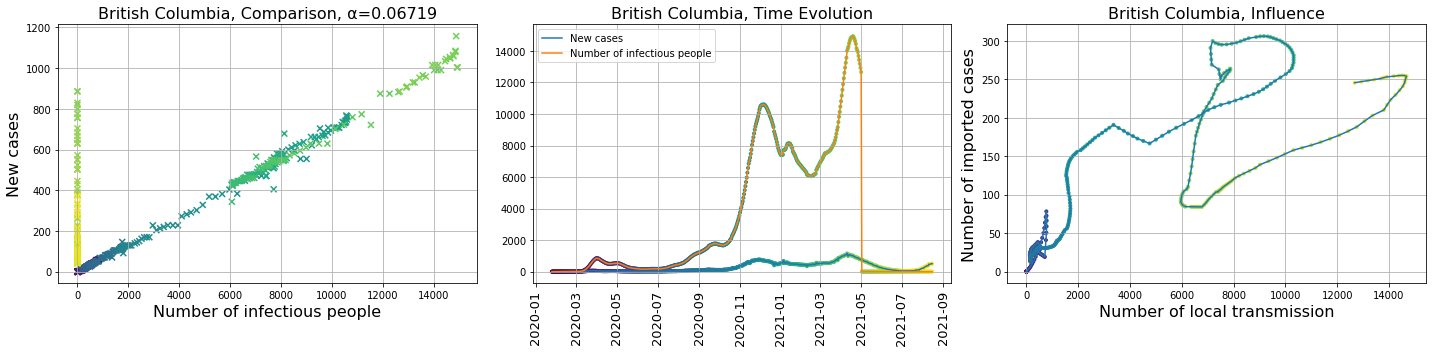

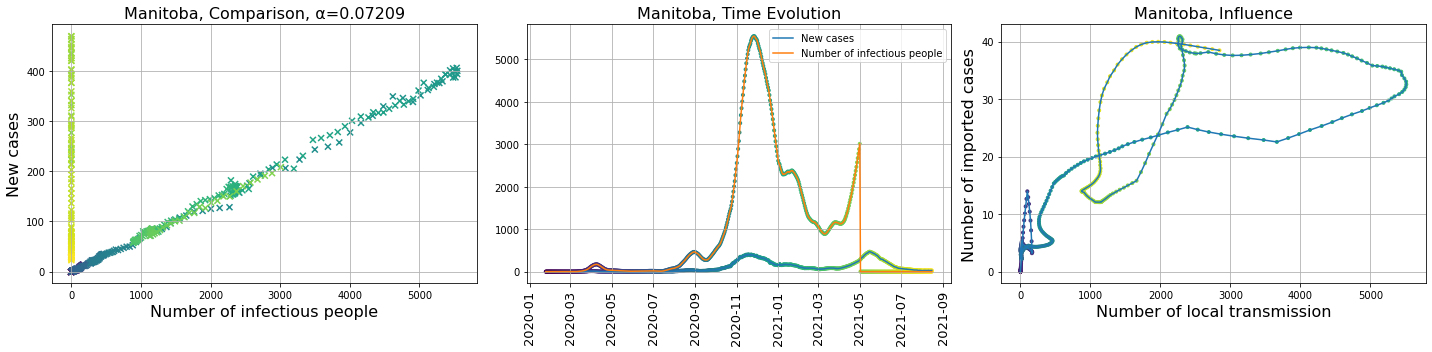

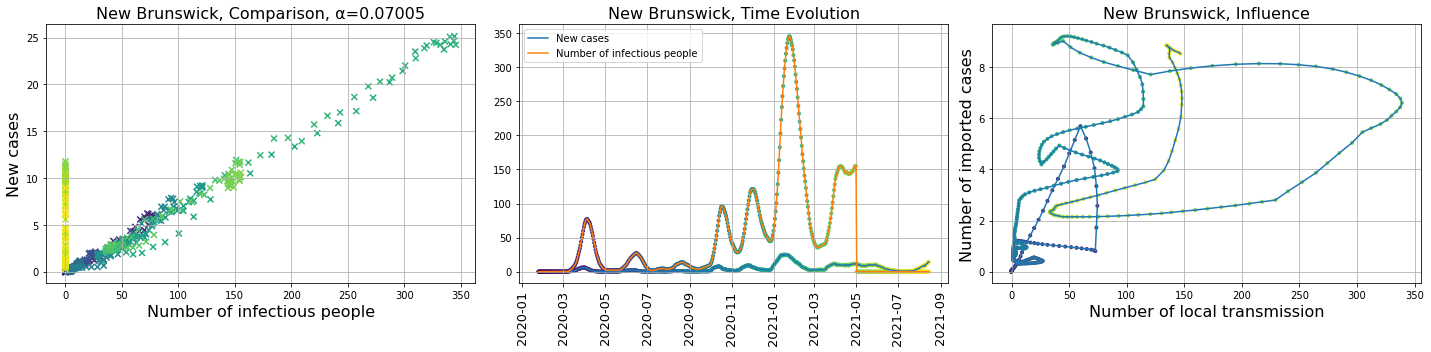

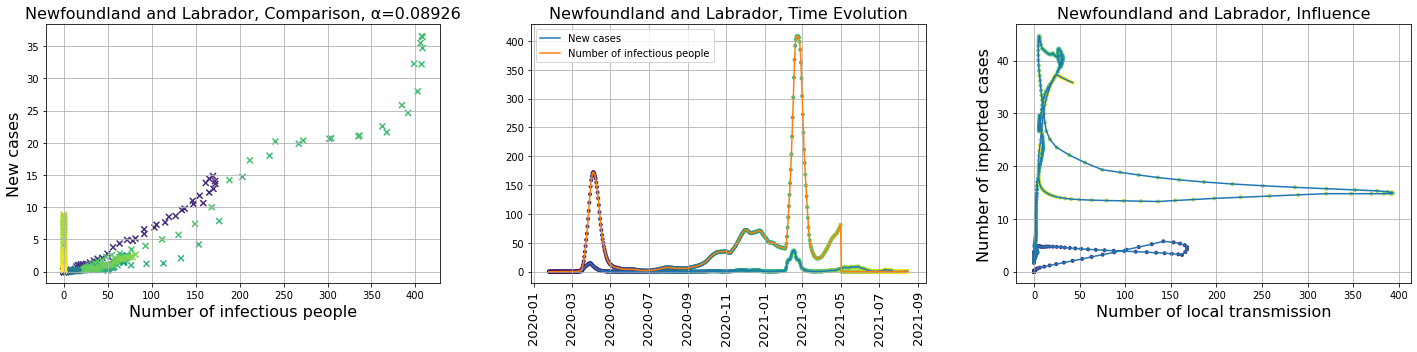

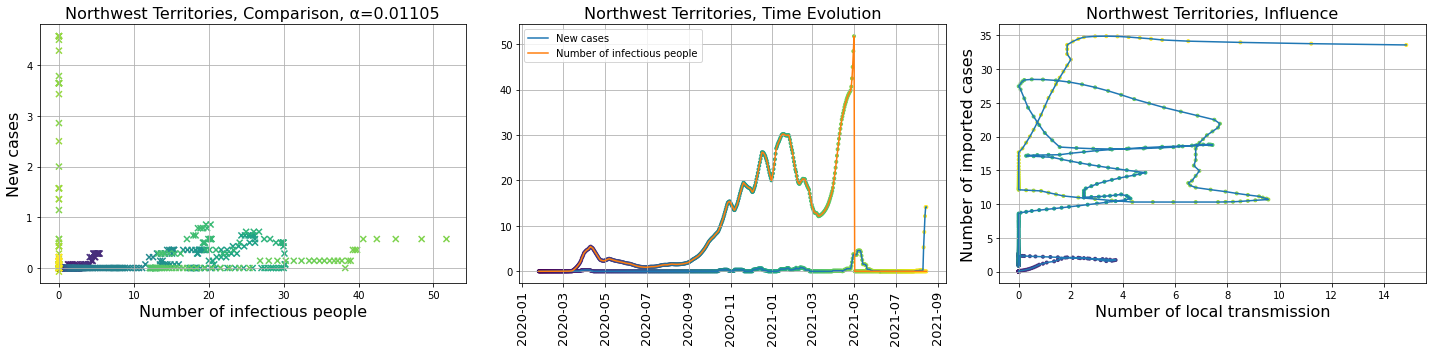

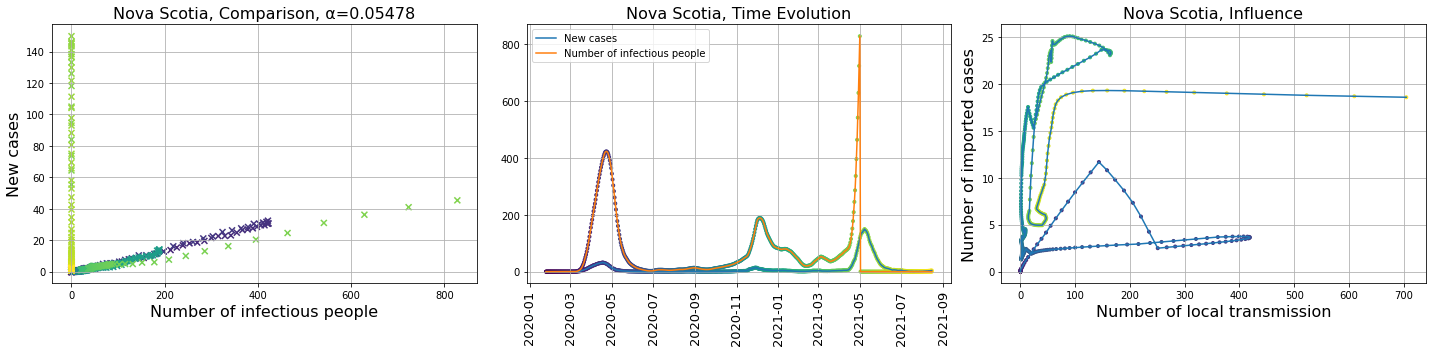

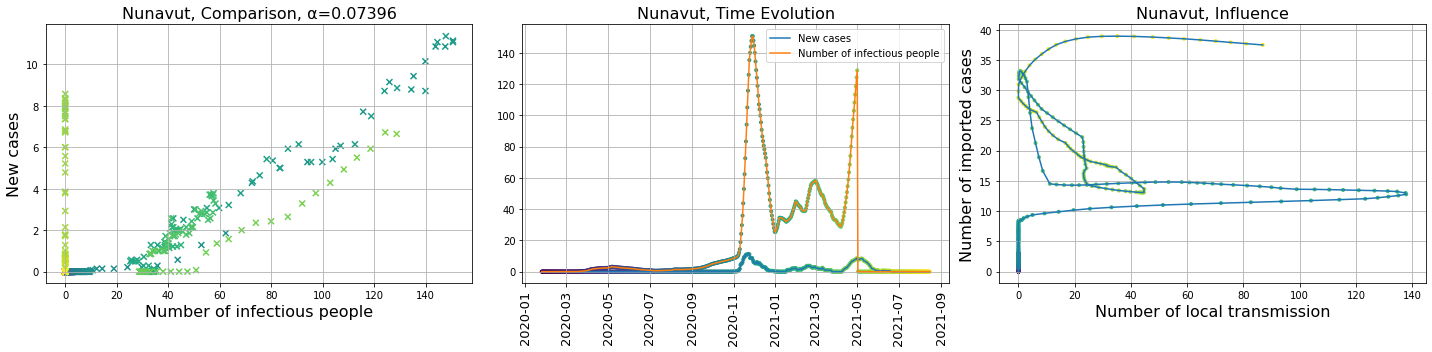

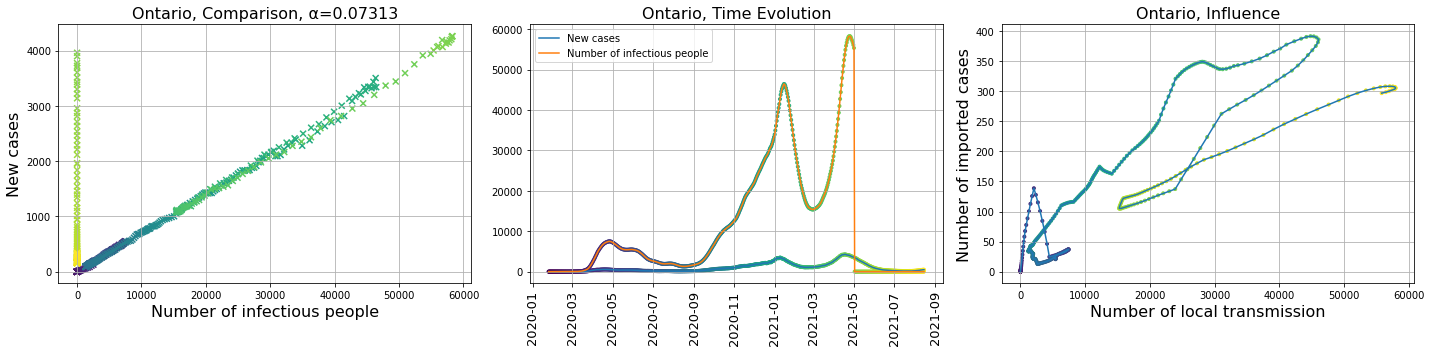

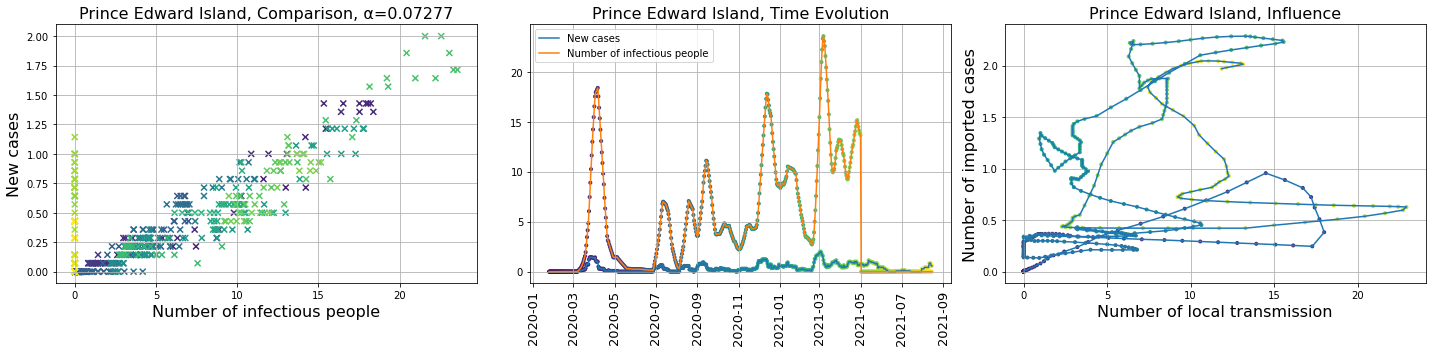

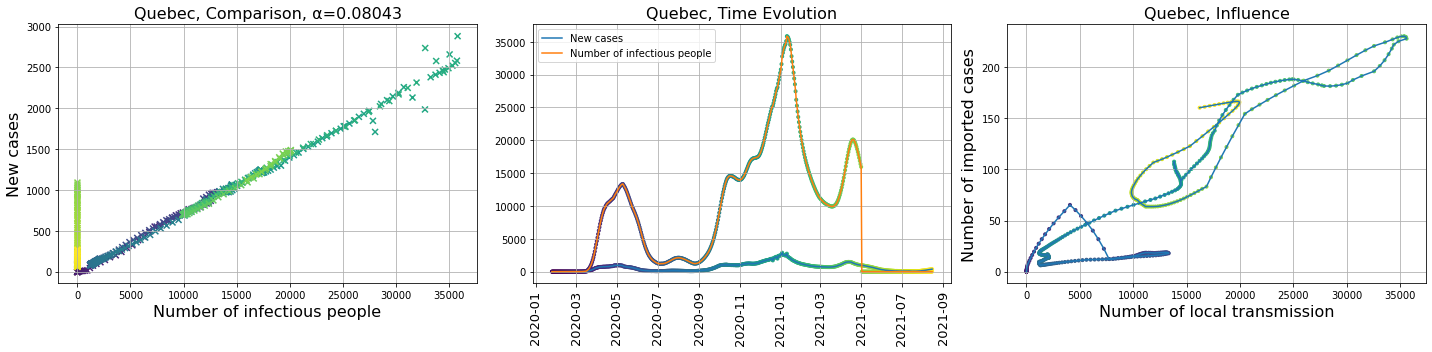

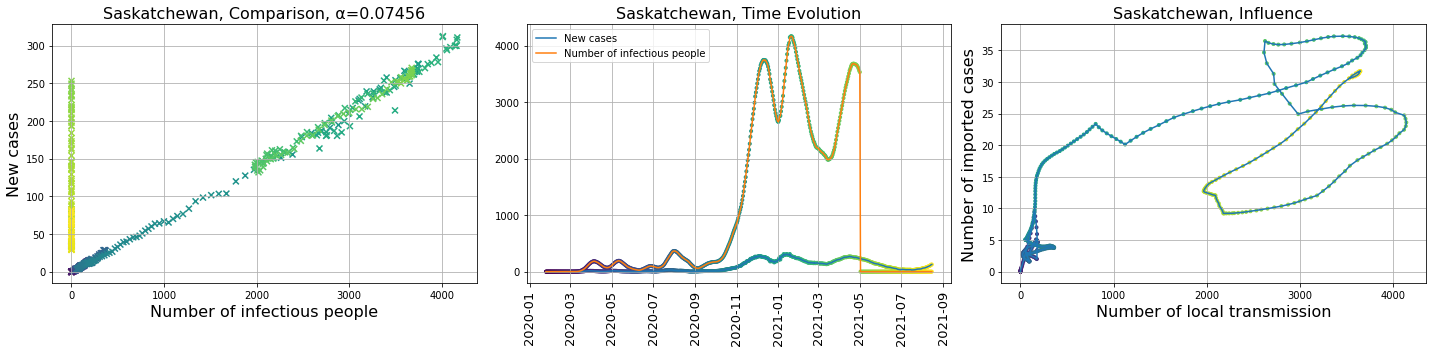

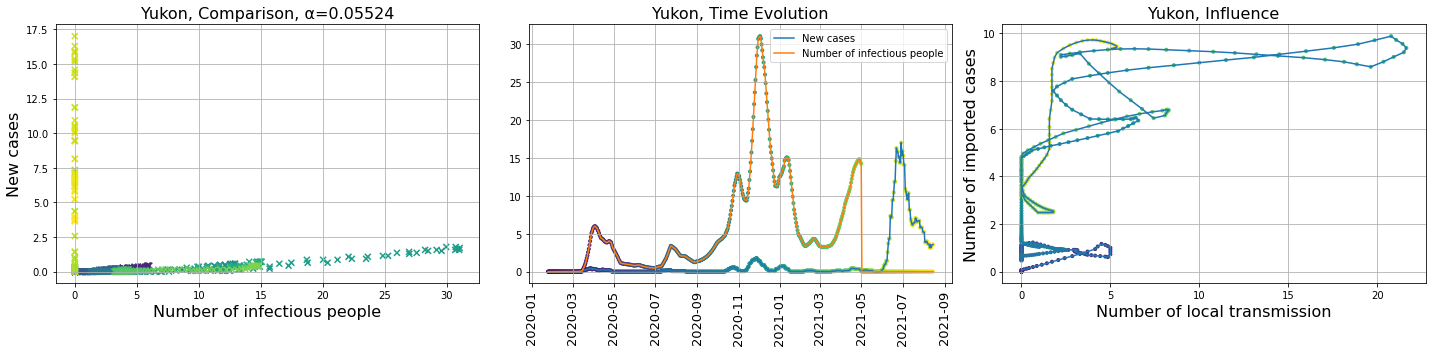

In [ ]:

def peakFind(x):
    y=np.exp(-(np.arange(-100,100)**2)/600)
    #plt.plot(x, label='x')
    d2=np.convolve(x,y)[100:]
    s=np.sign(np.diff(d2))
    s2=np.array([i for i in range(1, len(s)) if (0.5-s[i]*s[i-1]/2)*s[i-1]>0 ])
    #plt.plot(d2,label='conv')
    #for s in s2:
    #    plt.vlines(s, 0,np.max(x),color='r', linestyles='dashed')
    #plt.legend()
    return s2

plt.close('all')
for dt in [7]:
    for st in states:
        if(st!='Repatriated'):
            fig = plt.figure(figsize=(20,5))
            ax = plt.subplot(1,3,1)
            valores=df[['Daily_'+st, 'Intensity_'+st]].values
            peaks=peakFind(valores[:,1])
            #valores=valores[0:-10]
            tiempo=np.arange(0,(len(valores)-dt))
            x,y=valores[dt:,1],valores[0:(len(valores)-dt),0]
            ax.scatter(x,y,c=tiempo, marker='x')
            dist=x**2+y**2
            ind=np.argmax(dist)
            alfa=y[ind]/x[ind]
            #for p in peaks:
            #  ax.scatter(valores[p+dt,1],valores[p,0],marker='x', c='r')
            
            plt.ylabel('New cases',  fontsize=16)
            plt.xlabel('Number of infectious people',  fontsize=16) 
            plt.title(''+st+', Comparison, α='+str(np.round(alfa,5)), fontsize=16)#, Comparison, alfa='+str(np.round(alfa,5)))
            plt.grid()
            ax=plt.subplot(1,3,2)
            plt.plot(df.index, df['Daily_'+st], '-', label='New cases')
            ax.scatter(df.index, df['Daily_'+st], c=np.arange(0,(len(valores))), marker='.')
            plt.plot(df.index, df['Intensity_'+st], '-', label='Number of infectious people')
            ax.scatter(df.index, df['Intensity_'+st], c=np.arange(0,(len(valores))), marker='.')
            #for p in peaks:
            #  plt.vlines(df.index[p], 0, valores[p,1], colors='r', linestyles='dashed')
            plt.xticks(rotation=90,  fontsize=13)
            plt.grid()
            plt.legend()
            plt.title(''+st+', Time Evolution',  fontsize=16)
            
            ax=plt.subplot(1,3,3)
            #plt.plot(df.index, df['Intensity_'+st], '-', label='Intensity')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            #date2='2020-06-15'
            #date=pd.to_datetime(date2)
            #plt.plot(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], '-')
            #ax.scatter(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], c=np.arange(0,(len(df.loc[df.index<date]))), marker='.')
            #plt.xlabel('Number of internal infected people')
            #plt.ylabel('Number of external infected people')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            #plt.grid()
            #plt.title('State:'+st+', Influence up to '+date2)
            
            #ax=plt.subplot(1,4,4)
            #plt.plot(df.index, df['Intensity_'+st], '-', label='Intensity')
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            date=pd.to_datetime('2021-05-01')
            plt.plot(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], '-')
            ax.scatter(df.loc[df.index<date]['Intensity_own'+st], df.loc[df.index<date]['Intensity_ext'+st], c=np.arange(0,(len(df.loc[df.index<date]))), marker='.')
            plt.xlabel('Number of local transmission',  fontsize=16)#internal infected people
            plt.ylabel('Number of imported cases',  fontsize=16)#external infected people
            #plt.plot(df.index, df['Intensity_own'+st], '-', label='Intensity internal')
            #plt.plot(df.index, df['Intensity_ext'+st], '-', label='Intensity external')
            plt.grid()
            plt.title(''+st+', Influence',  fontsize=16)
            plt.tight_layout()

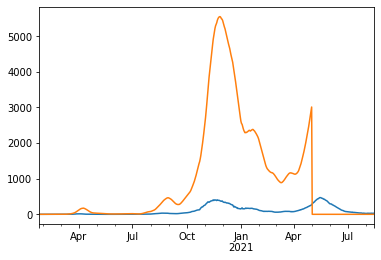

In [ ]:
df['Daily_Manitoba'].plot()
df['Intensity_Manitoba'].plot()

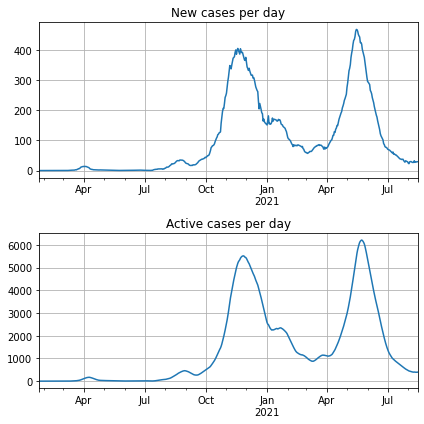

In [ ]:
#Figures for the document
st='Manitoba'
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
df['Daily_'+st].plot()
plt.title('New cases per day')
plt.grid()
plt.subplot(2,1,2)
df['active_'+st].plot()
plt.title('Active cases per day')
plt.grid()
plt.tight_layout()

In [ ]:
#Traffic volume analysis
def TrafficIntensity(row, countries, region):
  #Get the intensity of covid infection to regions
  K=np.sum([row['To_'+co] for co in states if co!='Repatriated'])
  if(K>0):
    factor=row['To_'+region]/K
  else:
    factor=0
  Io=0
  for i in range(len(countries)):
    if('From_'+countries[i] in row):
      Io+=factor*row['From_'+countries[i]]/30
  return Io

def getHistoricTrafficIntensity(countries, region):
  tmp=[]
  for i in range(len(df)):
    tmp.append(TrafficIntensity(df.iloc[i], countries, region))
  return tmp

for st in tqdm(states):
  if(st !='Repatriated'):
    tmp=getHistoricTrafficIntensity(countries, st)
    df['Traffic_'+st]=tmp


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


(array([737425., 737485., 737546., 737607., 737669., 737730., 737791.,
        737850., 737911., 737972., 738034.]),
 <a list of 11 Text major ticklabel objects>)

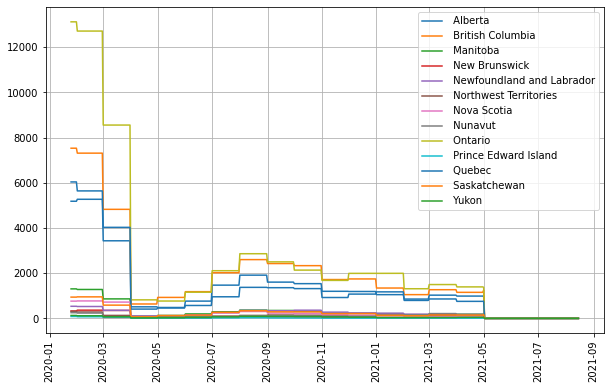

In [ ]:
plt.figure(figsize=(10,6))
for st in states:
  if(st !='Repatriated'):
    plt.plot(df.index, df['Traffic_'+st],'-', label=' '+st) #Traffic volume
plt.legend()
plt.grid()
plt.xticks(rotation=90)

In [ ]:
def read2(df, col, prefix=''):
    data=pd.pivot_table(df, values='Total volume', index='Date', columns=col, aggfunc=np.sum)
    data=data.asfreq('M', method='ffill')
    cols=data.columns
    cols=[prefix+co for co in cols]
    data.columns=cols
    data=data.fillna(0)
    data=data*10
    return data

source=read2(source_0, 'Country', prefix='From_')
dest=read2(dest_0, 'Province / state', prefix='To_')
#print(source.head())
def TrafficIntensity(origin, destination, countries, region):
  #Get the intensity of covid infection to regions
  K=np.sum([destination['To_'+st] for st in states if st!='Repatriated'])
  if(K>0):
    factor=destination['To_'+region]/K
  else:
    factor=0
  Io=0
  for i in range(len(countries)):
    if('From_'+countries[i] in origin):
      Io+=factor*origin['From_'+countries[i]]/30
  return Io

def getHistoricTrafficIntensity(countries, region):
  tmp=[]
  for i in range(len(source)):
    tmp.append(TrafficIntensity(source.iloc[i], dest.iloc[0], countries, region))
  return tmp

df2=pd.DataFrame(index=source.index)

for st in tqdm(states):
  if(st !='Repatriated'):
    tmp=getHistoricTrafficIntensity(countries, st)
    df2[''+st]=tmp


100%|██████████| 14/14 [00:01<00:00,  7.63it/s]


                  Alberta  British Columbia      Manitoba  New Brunswick  \
Date                                                                       
2010-01-31  145675.425403     172506.831203  40726.278687    9131.117751   
2010-02-28  141680.828220     167776.484269  39609.514637    8880.731407   
2010-03-31  159710.724262     189127.238691  44650.107921   10010.867827   
2010-04-30  155121.071675     183692.235348  43366.985048    9723.182666   
2010-05-31  170486.287342     201887.511992  47662.617297   10686.293590   

            Newfoundland and Labrador  Northwest Territories   Nova Scotia  \
Date                                                                         
2010-01-31               17772.615594           11092.180511  20993.069993   
2010-02-28               17285.268878           10788.019442  20417.414504   
2010-03-31               19484.942644           12160.871871  23015.676143   
2010-04-30               18924.998295           11811.401431  22354.268100   

[Text(0.5, 0, '2010-01'),
 Text(6.5, 0, '2010-07'),
 Text(12.5, 0, '2011-01'),
 Text(18.5, 0, '2011-07'),
 Text(24.5, 0, '2012-01'),
 Text(30.5, 0, '2012-07'),
 Text(36.5, 0, '2013-01'),
 Text(42.5, 0, '2013-07'),
 Text(48.5, 0, '2014-01'),
 Text(54.5, 0, '2014-07'),
 Text(60.5, 0, '2015-01'),
 Text(66.5, 0, '2015-07'),
 Text(72.5, 0, '2016-01'),
 Text(78.5, 0, '2016-07'),
 Text(84.5, 0, '2017-01'),
 Text(90.5, 0, '2017-07'),
 Text(96.5, 0, '2018-01'),
 Text(102.5, 0, '2018-07'),
 Text(108.5, 0, '2019-01'),
 Text(114.5, 0, '2019-07'),
 Text(120.5, 0, '2020-01'),
 Text(126.5, 0, '2020-07'),
 Text(132.5, 0, '2021-01')]

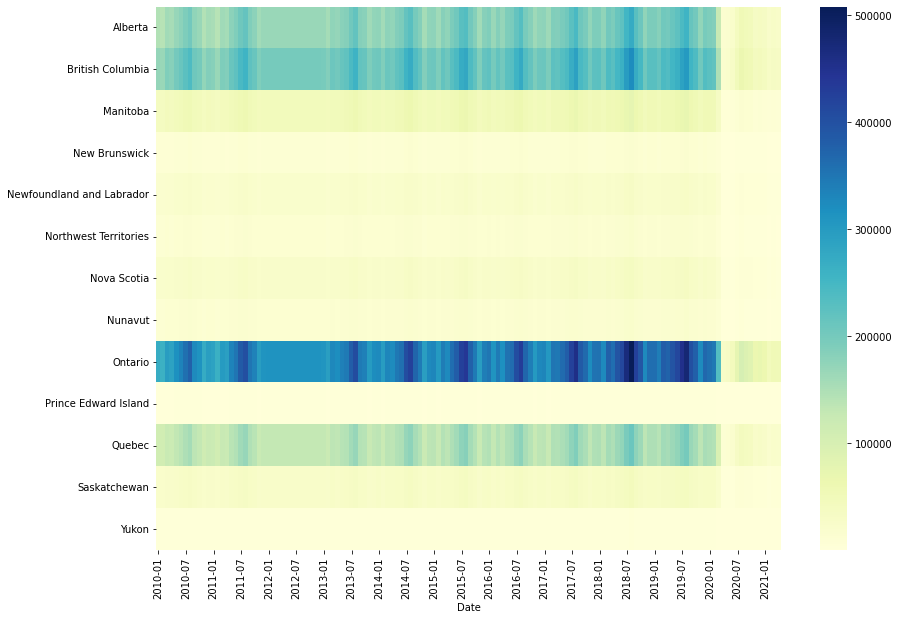

In [ ]:
#df2=df2
plt.figure(figsize=(14,10))
#plt.figure(figsize=(5,5))
#plt.title('Canadian provinces and territories flight arrivals from January 2010 to September 2021',  fontsize=12)
#plt.xlabel('', fontsize=12)
#plt.xticks(rotation=90)
#plt.ylabel('', fontsize=12)
#for st in states:
#  if(st !='Repatriated'):
#    plt.plot(df2.index, df2['Traffic_'+st],'-o', label='Traffic volume '+st)
#plt.legend()
#plt.grid()
#plt.xticks(rotation=90)
print(df2.head())
df3=df2.copy()
#df3=df3.drop(['Total','Month','Year','TotalNormalized'], axis=1)

import seaborn as sns
#sns.heatmap(df3.T, cmap="YlGnBu", xticklabels=6) palette="tab10", linewidth=2.5)
ax=sns.heatmap(df3.T, cmap="YlGnBu", xticklabels=6)
ticklabels = [df3.index[int(tick)].strftime('%Y-%m') for tick in ax.get_xticks()]
ax.set_xticklabels(ticklabels)

In [ ]:
#To represent each traffic curve as by the model: 
#V(month,state,year)=Vo(month)*Kyear*Kstate+w
#We need to find the best Vo(month) to minimize the noise projection
df2['Total']=df[['Traffic_Alberta', 'Traffic_British Columbia', 'Traffic_Manitoba',
       'Traffic_New Brunswick', 'Traffic_Newfoundland and Labrador',
       'Traffic_Northwest Territories', 'Traffic_Nova Scotia',
       'Traffic_Nunavut', 'Traffic_Ontario', 'Traffic_Prince Edward Island',
       'Traffic_Quebec', 'Traffic_Saskatchewan', 'Traffic_Yukon']].sum(axis=1)
#tr.columns=['Traffic_volume']
#df2['Date']=df2.index
#month=[]
#for i in range(len(tr)):
#  month.append(tr.index[i].month)
df2['Month']=df2.index.month
df2['Year']=df2.index.year

print(df2.head())

                  Alberta  British Columbia      Manitoba  New Brunswick  \
Date                                                                       
2010-01-31  145675.425403     172506.831203  40726.278687    9131.117751   
2010-02-28  141680.828220     167776.484269  39609.514637    8880.731407   
2010-03-31  159710.724262     189127.238691  44650.107921   10010.867827   
2010-04-30  155121.071675     183692.235348  43366.985048    9723.182666   
2010-05-31  170486.287342     201887.511992  47662.617297   10686.293590   

            Newfoundland and Labrador  Northwest Territories   Nova Scotia  \
Date                                                                         
2010-01-31               17772.615594           11092.180511  20993.069993   
2010-02-28               17285.268878           10788.019442  20417.414504   
2010-03-31               19484.942644           12160.871871  23015.676143   
2010-04-30               18924.998295           11811.401431  22354.268100   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


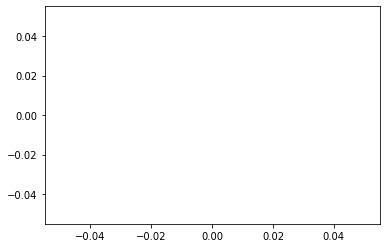

In [ ]:
#Get the reference value per year
years=[]
vols=[]
for y in df2['Year'].unique().tolist():
  vol=df2[df2['Year']==y]['Total'].sum()
  years.append(y)
  vols.append(vol)
vols=[v/vols[0] for v in vols]
#plt.plot(years, vols)
Ky={key:val for key, val in zip(years, vols)}

tmp=[]
for i in range(len(df2)):
  if(df2.iloc[i]['Year']<=2019):
    tmp.append(df2.iloc[i]['Total']/Ky[df2.iloc[i]['Year']])
  else:
    tmp.append(0)
df2['TotalNormalized']=tmp

Vm={}
for m in range(1,13):
  Vm[m]=df2[(df2['Year']<=2019) & (df2['Month']==m)]['TotalNormalized'].mean()
plt.plot(list(Vm.values()),'ob')
#print(Vm)

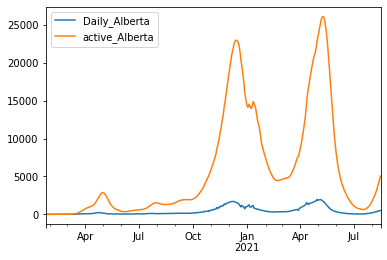

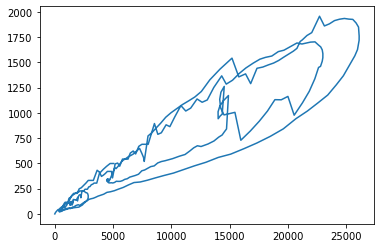

In [ ]:
df['Daily_Alberta'].plot()
df['active_Alberta'].plot()
plt.legend()
plt.figure()
plt.plot(df['active_Alberta'],df['Daily_Alberta'],'-')

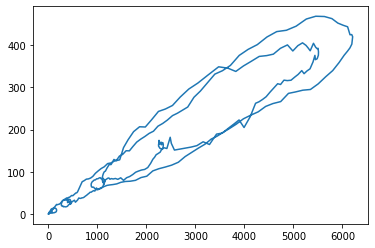

In [ ]:
#df[['Daily_Manitoba','active_Manitoba']].plot()
plt.plot(df['active_Manitoba'],df['Daily_Manitoba'])
with open('manitoba.txt','w') as f:
  for i in range(len(df)):
    f.write(str(df.iloc[i]['Daily_Manitoba'])+'\n')
  